In [1]:
import matplotlib.pyplot as plt
import json
import numpy as np

from tqdm.notebook import tqdm

from config import *

from easyric.caas_lite import TiffSpliter
from easyric.objects import Pix4D
from easyric.io import shp, geotiff, plot
from easyric.calculate import geo2raw, geo2tiff

import os
import shapefile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import shapely
import tifffile



In [2]:
root = r"Z:\hwang_Pro\data\2021_tanashi_broccoli\13_roi_on_raw"

In [3]:
def read_json(json_path):
    br_container = []
    bg_container = []
    with open(json_path, "r", encoding="utf-8") as f:
        js = json.loads(f.read())
        img_path = os.path.join(root, js["imagePath"][3:])
        for item in js["shapes"]:
            points = np.asarray(item["points"])
            points = np.append(points, points[0,:][None,:], axis=0)
            if item["label"] == "broccoli":
                br_container.append(points)
            elif item["label"] == "bg":
                bg_container.append(points)
            else:
                raise ValueError(f"Can not distinguish [{item['label']}]")
    return br_container, bg_container, img_path

read the roi

In [5]:
date = '210519'
roi_id = '105'
on_img = 'DJI_0084'

p = Paths(key=date, year=2021)

In [6]:
p.project_name

'broccoli_tanashi_5_20210519_P4RTK_15m_M_abefore'

In [9]:
roi_pd = pd.read_csv(f"Z:/hwang_Pro/data/2021_tanashi_broccoli/13_roi_on_raw/{p.project_name}.csv", index_col=0)
roi_pd_id = roi_pd.loc[int(roi_id),:]

roi_data = roi_pd_id[roi_pd_id.image == f'{on_img}.JPG']
roi_data

,image,xc,yc,select,roi,offset_x,offset_y
id,,,,,,,
105,DJI_0084.JPG,2991.108539,1348.976675,True,[[2685.75051205 1628.02490372]\n [2713.9781545...,2241,599


In [12]:
roi_data.roi.values[0]

'[[2685.75051205 1628.02490372]\n [2713.97815453 1044.38623865]\n [3296.46656672 1074.969909  ]\n [3253.38127611 1653.56711187]\n [2685.75051205 1628.02490372]]'

In [13]:
roi_str = roi_data.roi.values[0].replace('\n ', ',').replace(' ', ',').replace(',,', '')
roi_str

'[[2685.75051205,1628.02490372],[2713.97815453,1044.38623865],[3296.46656672,1074.969909],[3253.38127611,1653.56711187],[2685.75051205,1628.02490372]]'

In [14]:
roi = np.asarray(eval(roi_str))
roi

array([[2685.75051205, 1628.02490372],
       [2713.97815453, 1044.38623865],
       [3296.46656672, 1074.969909  ],
       [3253.38127611, 1653.56711187],
       [2685.75051205, 1628.02490372]])

In [15]:
roi_off = roi - np.asarray([roi_data.offset_x, roi_data.offset_y]).T
roi_off

array([[ 444.75051205, 1029.02490372],
       [ 472.97815453,  445.38623865],
       [1055.46656672,  475.969909  ],
       [1012.38127611, 1054.56711187],
       [ 444.75051205, 1029.02490372]])

In [16]:
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

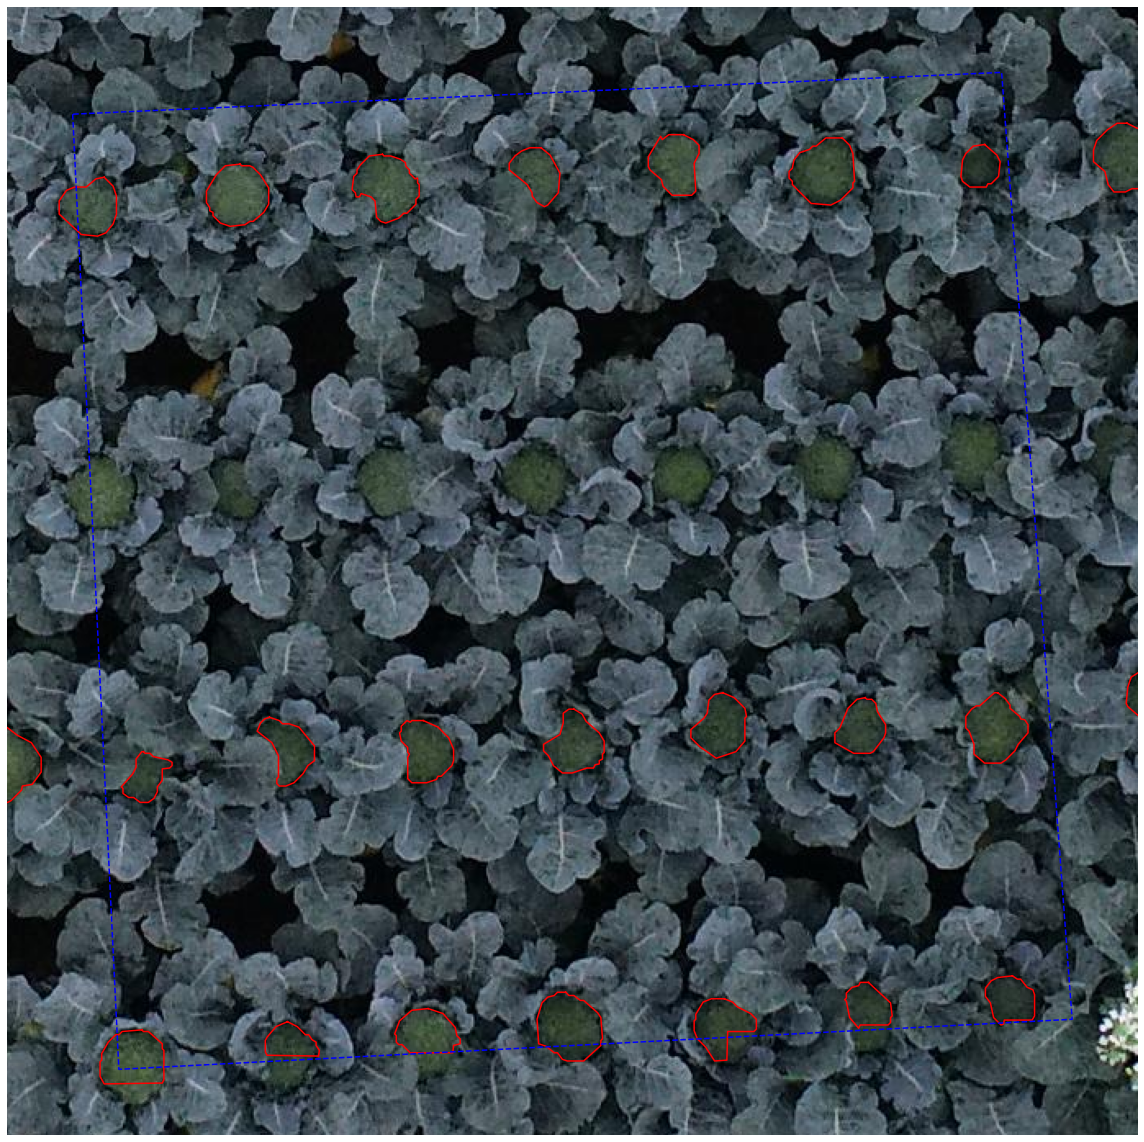

In [18]:
fig, ax = plt.subplots(1,1, figsize=(16,16))

json_name = f"pred_20{date}_{roi_id}_{on_img}.json"
# aux_name = json_name.replace("labeled","aux")

# aux_br, aux_bg, _ = read_json(os.path.join(root, "aux_backup", aux_name))
br, bg, imgPath = read_json(os.path.join(root, "pred", json_name))

ax.imshow(plt.imread(imgPath))

patches = []
# original results
# for p in aux_br:
#     polygon = Polygon(p, color="r", alpha=0.4, hatch="o")
#     patches.append(polygon)
    
# maual fixed
for p in br:
    ax.plot(*p.T, "r-")
    
for p in bg:
    ax.plot(*p.T, "g-")

ax.plot(*roi_off.T, 'b--')

bf = 40
xn,yn = roi_off.min(axis=0)
xm,ym = roi_off.max(axis=0)

ax.set_xlim([xn-bf, xm+bf])
ax.set_ylim([yn-bf, ym+bf])

# p = PatchCollection(patches, match_original=True)
# plt.gca().add_collection(p)

plt.axis("off")
plt.tight_layout()
plt.savefig("label_check/" + json_name[:-4]+".png")

plt.show()

In [24]:
imgPath

'Z:\\hwang_Pro\\data\\2021_tanashi_broccoli\\13_roi_on_raw\\broccoli_tanashi_5_20210520_P4RTK_15m_M_abefore/16_DJI_0628.JPG'